# Ultrasound Image Classification with CNN

This notebook implements a shallow CNN for classifying ultrasound images of different organs (bladder, kidney, liver, gallbladder, spleen, bowel).

## Features:
- Custom PyTorch dataset with data augmentation
- Shallow CNN architecture optimized for small datasets
- Training with validation monitoring
- Comprehensive evaluation and visualization


## Import Libraries


In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops_table, label
from skimage.filters import sobel
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Libraries imported successfully!
PyTorch version: 2.7.0
CUDA available: False


## Configuration


In [2]:
# Configuration parameters
class_names = ['bladder', 'kidney', 'liver', 'gallbladder', 'spleen', 'bowel']
data_dir = './datasets/img'
num_epochs = 100
learning_rate = 0.001
batch_size = 8
image_size = 128

print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Data directory: {data_dir}")
print(f"Training parameters: epochs={num_epochs}, lr={learning_rate}, batch_size={batch_size}")


Classes: ['bladder', 'kidney', 'liver', 'gallbladder', 'spleen', 'bowel']
Number of classes: 6
Data directory: ./datasets/img
Training parameters: epochs=100, lr=0.001, batch_size=8


## Custom Dataset Class

The `UltrasoundDataset` class handles loading and preprocessing of ultrasound images with optional data augmentation for training.


In [3]:
class UltrasoundDataset(Dataset):
    """Custom dataset for ultrasound images with augmentation"""
    
    def __init__(self, image_paths, labels, transform=None, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augment = augment
        
        # Define augmentation transforms
        if augment:
            self.augmentation = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
            ])
        else:
            self.augmentation = None
            
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        
        # Apply augmentation if training
        if self.augmentation:
            image = self.augmentation(image)
            
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        return image, label

print("UltrasoundDataset class defined successfully!")


UltrasoundDataset class defined successfully!


## CNN Model Architecture

The `ShallowCNN` is designed specifically for small datasets with three convolutional blocks and batch normalization.


In [4]:
class ShallowCNN(nn.Module):
    """Shallow CNN designed for small datasets"""
    
    def __init__(self, num_classes=2):
        super(ShallowCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def get_features(self, x):
        """Extract features from the last conv layer"""
        x = self.features(x)
        return x.view(x.size(0), -1)

# Create model instance
model = ShallowCNN(num_classes=len(class_names))
print(f"Model created with {len(class_names)} classes")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model created with 6 classes
Model parameters: 156,550


## Data Loading Functions


In [5]:
def load_data(data_dir, classes=['bladder', 'kidney']):
    """Load ultrasound images and labels"""
    images_train = []
    labels_train = []
    images_test = []
    labels_test = []
    
    # Load training data
    for i, class_name in enumerate(classes):
        train_dir = os.path.join(data_dir, 'train', class_name)
        test_dir = os.path.join(data_dir, 'test', class_name)
        
        # Training images
        if os.path.exists(train_dir):
            for img_name in os.listdir(train_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(train_dir, img_name)
                    images_train.append(img_path)
                    labels_train.append(i)
                
        # Test images
        if os.path.exists(test_dir):
            for img_name in os.listdir(test_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(test_dir, img_name)
                    images_test.append(img_path)
                    labels_test.append(i)
    
    return (np.array(images_train), np.array(labels_train), 
            np.array(images_test), np.array(labels_test))

print("Data loading function defined successfully!")


Data loading function defined successfully!


## Load and Prepare Data


In [6]:
# Load data
print("Loading data...")
X_train_paths, y_train, X_test_paths, y_test = load_data(data_dir, classes=class_names)

# Create validation set from training data
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    X_train_paths, y_train, test_size=0.2, random_state=42, 
    stratify=y_train if len(y_train) > 0 else None
)

print(f"Training samples: {len(X_train_paths)}")
print(f"Validation samples: {len(X_val_paths)}")
print(f"Test samples: {len(X_test_paths)}")

# Check class distribution
if len(y_train) > 0:
    unique, counts = np.unique(y_train, return_counts=True)
    for i, (cls, count) in enumerate(zip(unique, counts)):
        print(f"Class {class_names[cls]}: {count} training samples")


Loading data...
Training samples: 240
Validation samples: 60
Test samples: 60
Class bladder: 40 training samples
Class kidney: 40 training samples
Class liver: 40 training samples
Class gallbladder: 40 training samples
Class spleen: 40 training samples
Class bowel: 40 training samples


## Data Transforms and Datasets


In [7]:
# Define transforms
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = UltrasoundDataset(X_train_paths, y_train, transform_train, augment=True)
val_dataset = UltrasoundDataset(X_val_paths, y_val, transform_test, augment=False)
test_dataset = UltrasoundDataset(X_test_paths, y_test, transform_test, augment=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data transforms and loaders created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Data transforms and loaders created successfully!
Train batches: 30
Validation batches: 8
Test batches: 8


## Training Function


In [8]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001):
    """Train the CNN model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0
        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_accuracy = 100 * correct / total if total > 0 else 0
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        scheduler.step(avg_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, '
                  f'Val Accuracy: {val_accuracy:.2f}%')
    
    return model, train_losses, val_losses, val_accuracies

print("Training function defined successfully!")


Training function defined successfully!


## Train the Model

Now let's train the model. This will take some time depending on your hardware and the size of your dataset.


In [9]:
# Train model
print("Starting training...")
if len(train_loader) > 0 and len(val_loader) > 0:
    model, train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs=num_epochs, lr=learning_rate
    )
    print("Training completed!")
else:
    print("No training data found. Please check your data directory structure.")
    print("Expected structure: ./datasets/img/train/{class_name}/ and ./datasets/img/test/{class_name}/")


Starting training...
Training on device: cpu
Epoch [10/100], Train Loss: 0.4799, Val Loss: 0.1085, Val Accuracy: 96.67%
Epoch [20/100], Train Loss: 0.2918, Val Loss: 0.0528, Val Accuracy: 100.00%
Epoch [30/100], Train Loss: 0.3795, Val Loss: 0.0496, Val Accuracy: 98.33%
Epoch [40/100], Train Loss: 0.1349, Val Loss: 0.0054, Val Accuracy: 100.00%
Epoch [50/100], Train Loss: 0.1501, Val Loss: 0.0034, Val Accuracy: 100.00%
Epoch [60/100], Train Loss: 0.1504, Val Loss: 0.0034, Val Accuracy: 100.00%
Epoch [70/100], Train Loss: 0.0822, Val Loss: 0.0036, Val Accuracy: 100.00%
Epoch [80/100], Train Loss: 0.1165, Val Loss: 0.0024, Val Accuracy: 100.00%
Epoch [90/100], Train Loss: 0.0863, Val Loss: 0.0021, Val Accuracy: 100.00%
Epoch [100/100], Train Loss: 0.0922, Val Loss: 0.0020, Val Accuracy: 100.00%
Training completed!


## Visualization Functions


In [10]:
def plot_training_history(train_losses, val_losses, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(val_accuracies, label='Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, class_names):
    """Evaluate the model on test data"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Print classification report
    if len(all_labels) > 0:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_predictions, target_names=class_names))
        
        # Confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    return all_predictions, all_labels

print("Visualization functions defined successfully!")


Visualization functions defined successfully!


## Plot Training History

Let's visualize the training progress with loss and accuracy curves.


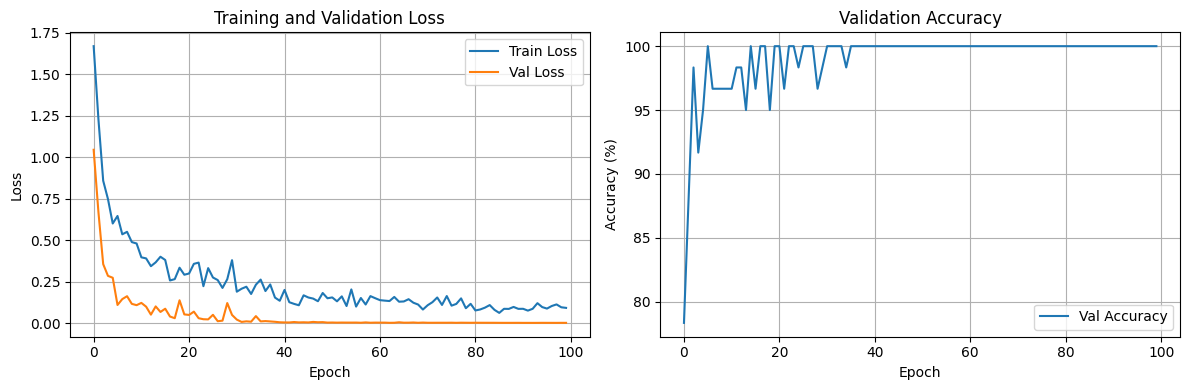

In [11]:
# Plot training history
if 'train_losses' in locals():
    plot_training_history(train_losses, val_losses, val_accuracies)
else:
    print("Training has not been completed yet. Run the training cell first.")


## Model Evaluation

Evaluate the trained model on the test set and generate classification metrics.


Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

     bladder       1.00      0.80      0.89        10
      kidney       0.77      1.00      0.87        10
       liver       1.00      0.90      0.95        10
 gallbladder       1.00      1.00      1.00        10
      spleen       1.00      1.00      1.00        10
       bowel       1.00      1.00      1.00        10

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



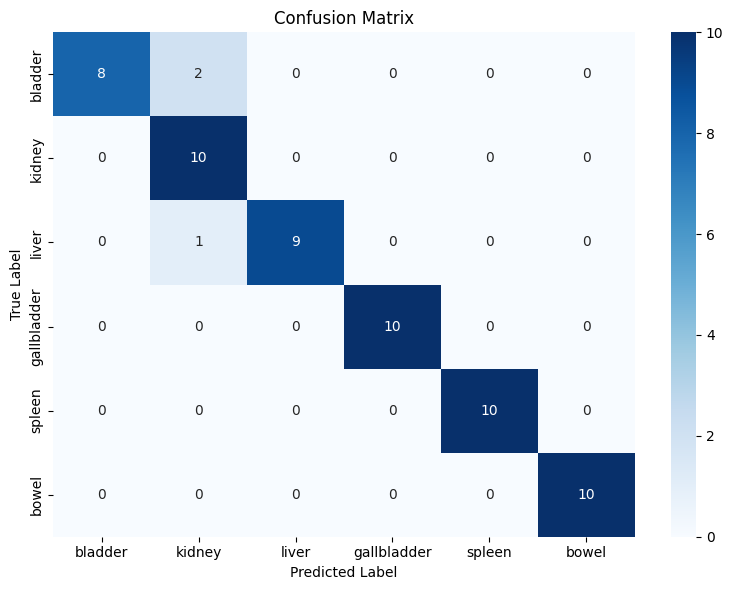

Evaluation completed!


In [12]:
# Evaluate on test set
print("Evaluating on test set...")
if len(test_loader) > 0 and 'model' in locals():
    predictions, labels = evaluate_model(model, test_loader, class_names)
    print("Evaluation completed!")
else:
    print("No test data found or model not trained yet.")


## Save and Load Model


In [13]:
# Save model
if 'model' in locals():
    torch.save(model.state_dict(), 'ultrasound_classifier.pth')
    print("Model saved as 'ultrasound_classifier.pth'")
    
    # Save model architecture info
    model_info = {
        'num_classes': len(class_names),
        'class_names': class_names,
        'image_size': image_size,
        'model_parameters': sum(p.numel() for p in model.parameters())
    }
    
    import json
    with open('model_info.json', 'w') as f:
        json.dump(model_info, f, indent=2)
    print("Model info saved as 'model_info.json'")
else:
    print("Model not available for saving.")


Model saved as 'ultrasound_classifier.pth'
Model info saved as 'model_info.json'


## Load Saved Model (Optional)

Use this cell to load a previously saved model.


In [14]:
# Load saved model (uncomment to use)
# model_path = 'ultrasound_classifier.pth'
# if os.path.exists(model_path):
#     loaded_model = ShallowCNN(num_classes=len(class_names))
#     loaded_model.load_state_dict(torch.load(model_path, map_location='cpu'))
#     loaded_model.eval()
#     print(f"Model loaded from {model_path}")
# else:
#     print(f"Model file {model_path} not found")

print("Model loading code ready (uncomment to use)")


Model loading code ready (uncomment to use)


## Sample Prediction Function

Function to make predictions on individual images.


In [15]:
def predict_single_image(model, image_path, transform, class_names):
    """Make prediction on a single image"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()
    
    return predicted_class, confidence_score, probabilities.cpu().numpy()[0]

def visualize_prediction(image_path, predicted_class, confidence, probabilities, class_names):
    """Visualize prediction results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Display image
    image = Image.open(image_path)
    ax1.imshow(image)
    ax1.set_title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2%}')
    ax1.axis('off')
    
    # Display probability distribution
    ax2.bar(class_names, probabilities)
    ax2.set_title('Class Probabilities')
    ax2.set_ylabel('Probability')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

print("Prediction functions defined successfully!")


Prediction functions defined successfully!


## Test Single Image Prediction

Use this cell to test predictions on individual images.


Sample image: ./datasets/img/test/bladder/bladder-0054.png
Predicted class: bladder
Confidence: 99.94%


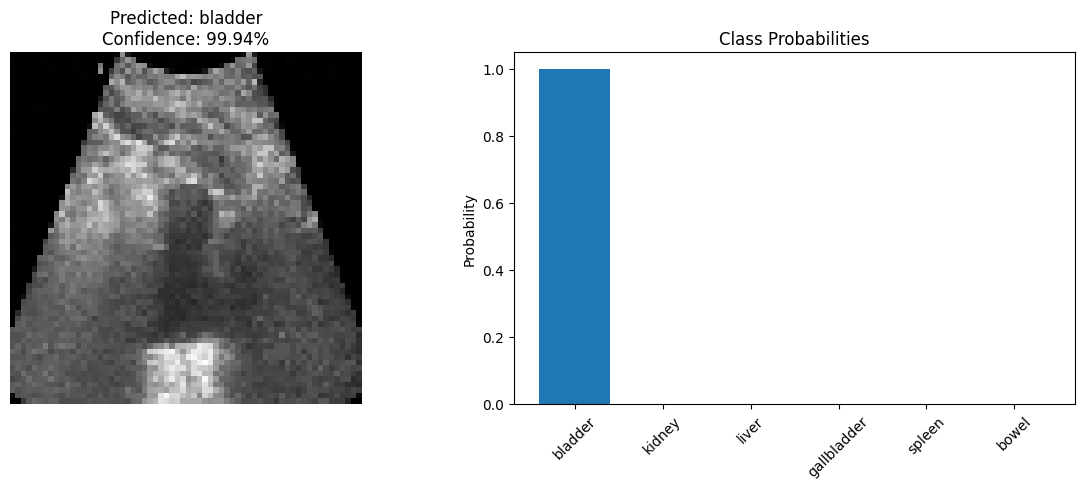

In [16]:
# Test prediction on a single image
if 'model' in locals() and len(X_test_paths) > 0:
    # Use the first test image as an example
    sample_image_path = X_test_paths[0]
    
    predicted_class, confidence, probabilities = predict_single_image(
        model, sample_image_path, transform_test, class_names
    )
    
    print(f"Sample image: {sample_image_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")
    
    # Visualize the prediction
    visualize_prediction(sample_image_path, predicted_class, confidence, probabilities, class_names)
else:
    print("Model not available or no test images found.")
    print("To test with your own image, replace 'sample_image_path' with your image path.")


## Summary

This notebook provides a complete pipeline for ultrasound image classification:

1. **Data Loading**: Loads images from organized directory structure
2. **Data Preprocessing**: Applies transforms and augmentation
3. **Model Architecture**: Shallow CNN optimized for small datasets
4. **Training**: Full training loop with validation monitoring
5. **Evaluation**: Comprehensive metrics and visualizations
6. **Prediction**: Functions for single image prediction

### Next Steps:
- Experiment with different architectures
- Try transfer learning with pre-trained models
- Implement cross-validation
- Add more sophisticated data augmentation
- Explore feature visualization techniques

### Requirements:
Make sure your data is organized as:
```
datasets/img/
├── train/
│   ├── bladder/
│   ├── kidney/
│   ├── liver/
│   ├── gallbladder/
│   ├── spleen/
│   └── bowel/
└── test/
    ├── bladder/
    ├── kidney/
    ├── liver/
    ├── gallbladder/
    ├── spleen/
    └── bowel/
```
